In [43]:
import re
import numpy as np 
import pandas as pd 
import spacy
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

## Creating the dataframe

In [44]:
bbc_df = pd.read_csv('New_Data/bbc.csv', encoding='iso-8859-1')
news_df = pd.read_csv('New_Data/mixed.csv', encoding='iso-8859-1')
news_large_df = pd.read_csv('New_Data/mixed_large.csv', encoding='iso-8859-1')


In [45]:
bbc_df = bbc_df.drop(columns=['Unnamed: 0']).rename(columns={'row_article': 'text'})
news_df = news_df.drop(columns=['author', 'date', 'headlines', 'read_more']).rename(columns=
                                                                          {'text': 'summary', 'ctext': 'text'})
news_large_df = news_large_df.rename(columns={'headlines': 'summary'})


In [46]:
data = news_large_df.append(news_df, ignore_index=True, sort=False)
data = data.append(bbc_df, ignore_index=True, sort=False)


In [47]:
data = data.iloc[:5000,:]

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   summary  5000 non-null   object
 1   text     5000 non-null   object
dtypes: object(2)
memory usage: 78.2+ KB


## Cleaning the data

In [49]:
def cleantext(column):
    for row in column:
        row=re.sub("(\\t)", ' ', str(row)).lower() 
        row=re.sub("(\\r)", ' ', str(row)).lower() 
        row=re.sub("(\\n)", ' ', str(row)).lower() 
        row=re.sub("(__+)", ' ', str(row)).lower()   
        row=re.sub("(--+)", ' ', str(row)).lower()   
        row=re.sub("(~~+)", ' ', str(row)).lower()   
        row=re.sub("(\+\++)", ' ', str(row)).lower()   
        row=re.sub("(\.\.+)", ' ', str(row)).lower()   
        row=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower()  
        row=re.sub("(mailto:)", ' ', str(row)).lower() 
        row=re.sub(r"(\\x9\d)", ' ', str(row)).lower() 
        row=re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(row)).lower() 
        row=re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(row)).lower() 
        row=re.sub("(\.\s+)", ' ', str(row)).lower() 
        row=re.sub("(\-\s+)", ' ', str(row)).lower() 
        row=re.sub("(\:\s+)", ' ', str(row)).lower() 
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() 
        try:
            url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
            repl_url = url.group(3)
            row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(row))
        except:
            pass 

        row = re.sub("(\s+)",' ',str(row)).lower()       
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() 
    
        yield row


In [50]:
nlp = spacy.load('en', disable=['ner', 'parser']) 
text = [str(doc) for doc in nlp.pipe(cleantext(data.text), batch_size=5000, n_threads=-1)]
summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(cleantext(data.summary), 
                                                               batch_size=5000, n_threads=-1)]

## New dataframe

In [51]:
max_text_len = 100
max_summary_len = 15

In [52]:
cleaned_text = np.array(data.text)
cleaned_summary = np.array(data.summary)

short_text = []
short_summary = []

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split()) <= max_summary_len and len(cleaned_text[i].split()) <= max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
new_data = pd.DataFrame({'text':short_text, 'summary':short_summary})

In [53]:
new_data.summary = new_data.summary.apply(lambda x : 'sostok '+ x + ' eostok')
new_data.summary[1]

'sostok Delhi techie wins free food from Swiggy for one year on CRED eostok'

## Model

In [57]:
from keras import backend as K 
import gensim
from numpy import *
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings


In [63]:
x_tr, x_tst, y_tr, y_tst = train_test_split(np.array(new_data.text), np.array(new_data.summary),
                                         test_size=0.2, random_state=12, shuffle=True)

In [64]:
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))


In [65]:
thresh = 4
cnt = 0
tot_cnt = 0
freq = 0
tot_freq = 0
for key, value in x_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    tot_freq = tot_freq + value
    if(value < thresh):
        cnt = cnt + 1
        freq = freq + value

x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr) 
x_tst_seq = x_tokenizer.texts_to_sequences(x_tst)
x_tr = pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_tst = pad_sequences(x_tst_seq, maxlen=max_text_len, padding='post')
x_voc = x_tokenizer.num_words + 1
print("size of X vocab{}".format(x_voc))


size of X vocab6439


In [66]:
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [67]:
thresh = 6
cnt = 0
tot_cnt = 0
freq = 0
tot_freq = 0
for key, value in y_tokenizer.word_counts.items():
    tot_cnt = tot_cnt+1
    tot_freq = tot_freq+value
    if(value < thresh):
        cnt = cnt + 1
        freq =freq + value

y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))
y_tr_seq = y_tokenizer.texts_to_sequences(y_tr) 
y_tst_seq = y_tokenizer.texts_to_sequences(y_tst) 
y_tr = pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_tst = pad_sequences(y_tst_seq, maxlen=max_summary_len, padding='post')
y_voc  =   y_tokenizer.num_words +1
print("Size of Y vocab{}".format(y_voc))


Size of Y vocab1324


In [68]:
ind = []
for i in range(len(y_tr)):
    cnt = 0
    for j in y_tr[i]:
        if j != 0:
            cnt = cnt + 1
    if(cnt==2):
        ind.append(i)

y_tr = np.delete(y_tr, ind, axis=0)
x_tr = np.delete(x_tr, ind, axis=0)

In [69]:
ind =[]
for i in range(len(y_tst)):
    cnt=0
    for j in y_tst[i]:
        if j != 0:
            cnt = cnt + 1
    if(cnt==2):
        ind.append(i)

y_tst = np.delete(y_tst,ind, axis=0)
x_tst = np.delete(x_tst,ind, axis=0)

In [70]:
K.clear_session()

latent_dim = 300
embedding_dim = 200

encoder_inputs = Input(shape=(max_text_len,))
enc_emb =  Embedding(x_voc, embedding_dim, trainable=True)(encoder_inputs)

encoder_lstm1 = LSTM(latent_dim,return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

decoder_inputs = Input(shape=(None,))

dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 200)     1287800     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100, 300), ( 601200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [71]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')


In [72]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)


## Fitting the data

In [73]:
history = model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:,1:],
                    epochs=50, callbacks=[es], batch_size=128, 
                    validation_data=([x_tst, y_tst[:,:-1]],
                                       y_tst.reshape(y_tst.shape[0], y_tst.shape[1], 1)[:,1:]))

Train on 3995 samples, validate on 999 samples
Epoch 1/50
3995/3995 [==============================] - 383s 96ms/sample - loss: 4.0810 - val_loss: 3.4906
Epoch 2/50
3995/3995 [==============================] - 381s 95ms/sample - loss: 3.4823 - val_loss: 3.1928
Epoch 3/50
3995/3995 [==============================] - 401s 100ms/sample - loss: 3.3604 - val_loss: 3.1374
Epoch 4/50
3995/3995 [==============================] - 477s 119ms/sample - loss: 3.3644 - val_loss: 3.1152
Epoch 5/50
3995/3995 [==============================] - 406s 102ms/sample - loss: 3.2881 - val_loss: 3.1213
Epoch 6/50
3995/3995 [==============================] - 386s 97ms/sample - loss: 3.2540 - val_loss: 3.0780
Epoch 7/50
3995/3995 [==============================] - 386s 97ms/sample - loss: 3.2227 - val_loss: 3.0656
Epoch 8/50
3995/3995 [==============================] - 385s 96ms/sample - loss: 3.1879 - val_loss: 3.0516
Epoch 9/50
3995/3995 [==============================] - 384s 96ms/sample - loss: 3.1540 - val_

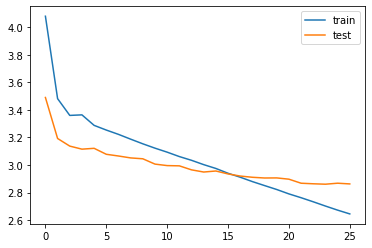

In [74]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label = 'train')
pyplot.plot(history.history['val_loss'], label = 'test')
pyplot.legend()
pyplot.show()

In [75]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [76]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, 
                                                                             decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [77]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [78]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString = newString + reverse_target_word_index[i] + ' '
    return newString

def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if(i!=0):
            newString = newString + reverse_source_word_index[i] + ' '
    return newString

In [5]:
# for i in range(0,10):
#     print("Review:",seq2text(x_tst[i]))
#     print("Original summary:",seq2summary(y_tr[i]))
#     print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
#     print("\n")

## Testing the model

In [163]:
sample_test = 
""" 
We know the problem with these accounts should be resolved now and we apologise for inconvenience."""

In [164]:
len(sample_test)

100

In [165]:
x_tokenizer.fit_on_texts(sample_test)
x_val_seq = x_tokenizer.texts_to_sequences(sample_test)
x_val = pad_sequences(x_val_seq, padding='post')
x_val = np.reshape(x_val,(x_val.size,))

In [167]:
x_val

array([ 0,  4,  1,  0, 20,  3,  2,  4,  0, 10, 11,  1,  0, 14, 12,  2, 15,
        5,  1, 16,  0,  4,  6, 10, 11,  0, 17, 16,  7,  6,  5,  0,  7,  8,
        8,  2, 18,  3, 10,  9,  0,  9, 11,  2, 18,  5, 13,  0, 15,  1,  0,
       12,  1,  9,  2,  5, 19,  1, 13,  0,  3,  2,  4,  0,  7,  3, 13,  0,
        4,  1,  0,  7, 14,  2,  5,  2, 17,  6,  9,  1,  0, 21,  2, 12,  0,
        6,  3,  8,  2,  3, 19,  1,  3,  6,  1,  3,  8,  1,  0,  0])

In [171]:
x_val.shape

(100,)

In [173]:
decode_sequence(x_val.reshape(1,max_text_len))

' man who to get in up'